## Frameworks

In [1]:
import gurobipy as gp
from gurobipy import GRB
import json
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

## 1) Load Instance

In [2]:
start = time.time()

In [3]:
#path="instances/test.json"
path="instances/toy_instance.json"
#path="instances/medium_instance.json"
#path="instances/large_instance.json"

# JSON file
f = open (path, "r")
  
# Reading from file
data = json.loads(f.read())

In [4]:
# Gains
Gm=[]
for job in data["jobs"]:
    Gm.append(job['gain'])
Gm=np.array(Gm)

# Penalty
Pm=[]
for job in data["jobs"]:
    Pm.append(job['daily_penalty'])
Pm=np.array(Pm)

# Due Date
Dm=[]
for job in data["jobs"]:
    Dm.append(job['due_date'])
Dm=np.array(Dm)

# Penalty per day
Penalty=[]
for job in data["jobs"]:
    job_penalty=[]
    p=0
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p+=job["daily_penalty"]
        job_penalty.append(p)
    Penalty.append(job_penalty)
Penalty=np.array(Penalty)

# Profit per day
Profit=[]
for job in data["jobs"]:
    job_benef=[]
    p=job['gain']
    for t in range(data["horizon"]):
        if (t>job["due_date"]-1):
            p-=job["daily_penalty"]
        job_benef.append(p)
    Profit.append(job_benef)
Profit=np.array(Profit)

# Vacations per day and per employee
Vacations=[]
for e in data["staff"]:
    e_planning=[]
    v=e['vacations']
    for t in range(data["horizon"]):
        if (t+1 in v):
            e_planning.append(1)
        else:
            e_planning.append(0)
    Vacations.append(e_planning)
Vacations=np.array(Vacations)

# Employee qualifications
Qualifications_staff=[]
for staff in data["staff"]:
    list_staff=[]
    for q in data["qualifications"]:
        if(q in staff["qualifications"]):
            list_staff.append(1)
        else:
            list_staff.append(0)
    Qualifications_staff.append(list_staff)
Qualifications_staff = np.array(Qualifications_staff)

# Jobs Qualifications
Qualifications_job=[]
for job in data["jobs"]:
    #working_days_per_qualification
    list_job=[]
    for q in data["qualifications"]:
        try:
            val=job['working_days_per_qualification'][q]
        except:
            val=0
        list_job.append(val)
    Qualifications_job.append(list_job)
Qualifications_job=np.array(Qualifications_job)

## 2) Model

In [5]:
###
# MODEL
model = gp.Model()

horizon=data["horizon"]
qualifs=len(data["qualifications"])
projects=len(data["jobs"])
staffs=len(data["staff"])

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-29


## 3) Variables

In [6]:
###
# VARIABLES

# Planning 
Planning = model.addMVar(
                        shape=(staffs,horizon,projects,qualifs),
                        vtype=GRB.BINARY,
                        name="Planning"
                        )

# Delay 
Delay_project = model.addVars(
                                projects,
                                lb=0,
                                ub=horizon,
                                vtype=GRB.INTEGER,
                                name="Delay_project"
                            ) 

# End Date 
End_project = model.addVars(
                                projects,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

# Realisation Boolean
Realisation = model.addVars(
                                projects,
                                vtype=GRB.BINARY,
                                name="Realisation"
                            )

# Begin 

Begin_project = model.addVars(
                                projects,
                                vtype=GRB.INTEGER,
                                name="End_project"
                            ) 

Lenght_project = model.addVars(
                                projects, 
                                vtype=GRB.INTEGER, 
                                name="Lenght_project")

Max_duration_lenght = model.addVar(
                                    vtype = GRB.INTEGER,
                                    name = "Max_duration_lenght")


## 4) Constraints

In [7]:
###
# CONSTRAINTS

#1 Uicity of affectation 
model.addConstrs(
    (gp.quicksum(gp.quicksum(Planning[staff][t]))<= 1
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
    ),
    name="staff_qualif_unicity"
) 

#2 Vacations
model.addConstrs(
    (Planning[staff][t][job][qualif]<=1-Vacations[staff][t] 
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Vacations_constraint"
) 


#3 Qualification staff
model.addConstrs(
    (Planning[staff][t][job][qualif]<=Qualifications_staff[staff][qualif]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
    ),
    name="Qualif_staff_constraint"
) 


# Definition d'une liste de la somme des temps de qualifs par projet
Max_temp_qualif_job=[]
for job in range(len(data["jobs"])):
    l_job=[]
    for qualif in range(len(data["qualifications"])):
        temp_qualif_job=0
        for t in range(data["horizon"]):
            for staff in range(len(data["staff"])):
                temp_qualif_job+=Planning[staff][t][job][qualif]
        l_job.append(temp_qualif_job)
    Max_temp_qualif_job.append(l_job)
Max_temp_qualif_job


#4 Couverture des qualifs => realisation
model.addConstrs(
        (Max_temp_qualif_job[job][qualif] >= Realisation[job] *  Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
        ), name = "cover_qualif"
)

#5 Unicity realisation
model.addConstrs(
    (Max_temp_qualif_job[job][qualif] <= Qualifications_job[job][qualif]
            for job in range(len(data["jobs"]))
            for qualif in range(len(data["qualifications"]))
), name = "project_done_once")

#6 end project 
model.addConstrs(
   (Planning[staff][t][job][qualif] * t+1 <= End_project[job]
        for staff in range(len(data["staff"]))
        for t in range(data["horizon"])
        for job in range(len(data["jobs"]))
        for qualif in range(len(data["qualifications"]))
), name = "end_project_date")

#7 Delay 
model.addConstrs(
    (End_project[job] - Dm[job] <= Delay_project[job]
       for job in range(len(data["jobs"]))
    ), name="delay_project"
)



Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

## 5) Objectives

In [8]:
model.ModelSense = GRB.MAXIMIZE

### Z1: Maximize Profit

In [9]:
# Objectif Unique : 
# Z1 = gp.quicksum(Realisation.values()*(Gm-Pm*Delay_project.values()))
# model.setObjective(Z1,GRB.MAXIMIZE)

In [10]:
# ici on suppose que si le projet n'est pas réalisé alors il n'est pas commencé donc pas de delay ?
# à vérifier ! (ajouter constraint #9 ?)

Z1 = gp.quicksum((Realisation.values()*Gm)-(Pm*Delay_project.values()))

In [11]:
model.setObjectiveN(
    Z1, 
    index=0, 
    priority=3, 
    name='Profit', 
    weight=1)

### Z2: Minimize Number of Projects per Employee

In [12]:
Include_Z2 = True

In [13]:
# Jobs done by one staff
jobs_staffeur = model.addMVar(shape=(staffs,projects),vtype=GRB.BINARY,name="jobs_staffeur")

for staff in range(staffs):
    for job in range(projects):
        val=[]
        for t in range(horizon):
            for qualif in range(qualifs):
                val.append(Planning[staff][t][job][qualif])
        model.addConstr((jobs_staffeur[staff][job] == gp.max_(val)))

# Sum of all jobs for one staff
sum_staff_jobs = model.addVars(staffs,vtype=GRB.INTEGER, name="sum_staff_jobs")         

for staff in range(staffs):
    model.addConstr((sum_staff_jobs[staff]==gp.quicksum(jobs_staffeur[staff])))


In [14]:
if Include_Z2:
    for staff in range(staffs):
        model.setObjectiveN(sum_staff_jobs[staff], 
                            index=1+staff, 
                            priority=1, 
                            weight=-1)  #weight = -1 to minimize


### Z3: Minimize Realisation Time

In [15]:
Include_Z3 = False
Include_Z3_test= True

In [16]:
#on ne peut commencer un projet avant le jour 1
for job in range(projects):
    model.addConstr(Begin_project[job] >= 1)

## création d'une liste pour chaque jour met soit 0 si le projet n'est pas travaillé soit le jour en question
## l'idée est d'ensuite récupérer le min de cette liste
for job in range(projects):
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                model.addConstr(Begin_project[job] <= Planning[staff][t][job][qualif]*(t+1) +horizon*(1-Planning[staff][t][job][qualif]))

#lenght of a project
for job in range(projects):
    model.addConstr(End_project[job] + 1 - Begin_project[job] <= Lenght_project[job])

#max lenght of a project
for job in range(projects):
    model.addConstr(Lenght_project[job] <= Max_duration_lenght)

In [17]:
model.setObjectiveN(
    -Max_duration_lenght, 
    index = 2, 
    priority = 1)

## 6) Optimize

In [18]:
# epsilon

In [19]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8259U CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 968 rows, 269 columns and 2003 nonzeros
Model fingerprint: 0x630d0d8c
Model has 15 general constraints
Variable types: 0 continuous, 269 integer (245 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 5e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 4 objectives (2 combined) ...
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 793 rows and 140 columns
Presolve time: 0.00s
Presolved: 175 rows and 129 columns
---------------

## 7) Results

In [20]:
end = time.time()
print("Time taken: ", round(end - start,2), "seconds || ",round((end - start)/60,2), "minutes" )
# toy : 1s
# medium : 53s
#large : 3,7 min

Time taken:  1.57 seconds ||  0.03 minutes


### Objectives

In [21]:
# Z1
print("Z1: Maximize Profit\n")
print("Solution || Best ")
print(" ",model.objVal,"  || ",Gm.sum())
print("\nDetails: Gain - Delay * Daily Penalty\n")
for job in range(projects):
    if(int(Realisation[job].x)==1):
        print(data["jobs"][job]["name"],":",data["jobs"][job]["gain"],"-",int(Delay_project[job].x),"*",data["jobs"][job]["daily_penalty"])
    else:
        print(data["jobs"][job]["name"],": Not Done")
print("------------")
print("Total =",model.objVal)


Z1: Maximize Profit

Solution || Best 
  65.0   ||  80

Details: Gain - Delay * Daily Penalty

Job1 : 20 - 0 * 3
Job2 : Not Done
Job3 : 15 - 0 * 3
Job4 : 20 - 0 * 3
Job5 : 10 - 0 * 3
------------
Total = 65.0


In [22]:
# Z2
print("Z2: Minimize Number of Projects per Employee\n")
print("Staff || Job(s) ||  Name")
for i in range(len(data["staff"])):
    print(" ",i,"  ||  ",int(sum_staff_jobs[i].x),"   || ",data["staff"][i]["name"])

Z2: Minimize Number of Projects per Employee

Staff || Job(s) ||  Name
  0   ||   2    ||  Olivia
  1   ||   2    ||  Liam
  2   ||   2    ||  Emma


In [38]:
# Z3
print("Z3: Minimize Realisation Time\n")
print("  Job   || Begin ||  End  || Delta")
for i in range(len(data["jobs"])):
    print("  ",i+1,"   || ",int(Begin_project[i].x),"   ||  ",int(End_project[i].x),"  || ",int(End_project[i].x-Begin_project[i].x))  

Z3: Minimize Realisation Time

  Job   || Begin ||  End  || Delta
   1    ||  1    ||   3   ||  2
   2    ||  1    ||   1   ||  0
   3    ||  2    ||   4   ||  2
   4    ||  1    ||   3   ||  2
   5    ||  3    ||   5   ||  2


### Constraints

In [24]:
#Couverture qualif
print("- Couverture Qualifications -\n")
for job in range(len(data["jobs"])):
    print(data["jobs"][job]["name"],int(Realisation[job].x)==1)
    for qualif in range(qualifs):
        val=0
        for t in range(horizon):
            for staff in range(staffs):
                val+=int(Planning[staff][t][job][qualif].x)
        print(" .",data["qualifications"][qualif],val)
    print("Expected",Qualifications_job[job])
    print("---")

- Couverture Qualifications -

Job1 True
 . A 1
 . B 1
 . C 1
Expected [1 1 1]
---
Job2 False
 . A 0
 . B 0
 . C 0
Expected [1 2 0]
---
Job3 True
 . A 1
 . B 0
 . C 2
Expected [1 0 2]
---
Job4 True
 . A 0
 . B 2
 . C 1
Expected [0 2 1]
---
Job5 True
 . A 0
 . B 0
 . C 2
Expected [0 0 2]
---


In [39]:
# Due dates
print("- Due Dates -\n")
print("Project || Expected || End || Delay")
for i in range(len(data["jobs"])):
    print("  ",i+1,"   ||    ",data["jobs"][i]["due_date"],"   || ",int(End_project[i].x)," || ",int(Delay_project[i].x))

- Due Dates -

Project || Expected || End || Delay
   1    ||     3    ||  3  ||  0
   2    ||     3    ||  1  ||  0
   3    ||     4    ||  4  ||  0
   4    ||     3    ||  3  ||  0
   5    ||     5    ||  5  ||  0


In [26]:
# Unicité affectation et congé
print("- Unicité Affectation et Congés -\n")
for t in range(horizon):
    print("Jour",t+1)
    for staff in range(staffs):
        val=0
        for job in range(len(data["jobs"])):
            for qualif in range(qualifs):
                val+=int(Planning[staff][t][job][qualif].x)
        vacation= t+1 in data["staff"][staff]["vacations"]
        if(vacation):
            print(" .",data["staff"][staff]["name"],val,"Vacation")
        else:
            print(" .",data["staff"][staff]["name"],val)
    print("---")

- Unicité Affectation et Congés -

Jour 1
 . Olivia 1
 . Liam 0 Vacation
 . Emma 1
---
Jour 2
 . Olivia 1
 . Liam 1
 . Emma 0 Vacation
---
Jour 3
 . Olivia 1
 . Liam 1
 . Emma 1
---
Jour 4
 . Olivia 1
 . Liam 1
 . Emma 1
---
Jour 5
 . Olivia 1
 . Liam 0
 . Emma 0
---


### Visualization

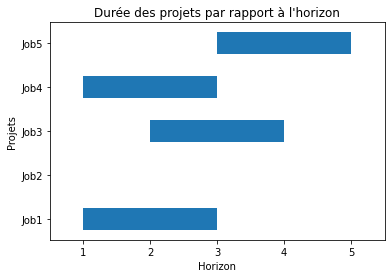

In [27]:
projects_duration = [Realisation[i].x*(End_project[i].x-Begin_project[i].x) for i in range(len(data["jobs"]))]
projects_names = [job["name"] for job in data["jobs"]]
starts_dates=[Begin_project[i].x for i in range(len(data["jobs"]))]

plt.barh(projects_names, projects_duration,left= starts_dates, height=0.5)

plt.xlim(0.5, horizon+0.5)
plt.ylabel('Projets')
plt.xlabel('Horizon')
plt.title("Durée des projets par rapport à l'horizon")

plt.show()

In [28]:
res={}
for job in range(projects):
    val={}
    for t in range(horizon):
        for staff in range(staffs):
            for qualif in range(qualifs):
                if(int(Planning[staff][t][job][qualif].x)==1.0):
                    val[t]=(staff,qualif)
    res[job]=val
res

{0: {0: (2, 2), 1: (1, 0), 2: (1, 1)},
 1: {},
 2: {2: (2, 2), 3: (2, 2)},
 3: {0: (0, 1), 1: (0, 1), 2: (0, 2)},
 4: {3: (0, 2), 4: (0, 2)}}

In [29]:
for i, project in enumerate(res.keys()):
    print(i,project)

0 0
1 1
2 2
3 3
4 4


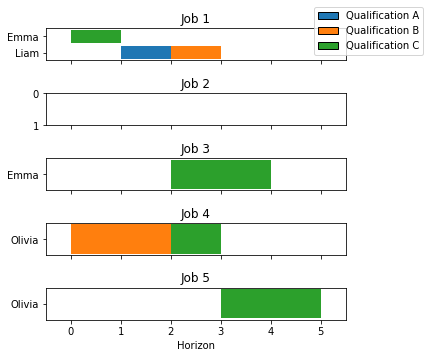

In [30]:
staff_names=[data["staff"][i]["name"] for i in range(staffs)]

projects_chart = projects
fig, axs = plt.subplots(projects_chart, 1, figsize=(5, 5), sharex=True)

color_map = {}
for i in range(qualifs):
    color_map[i]='C'+str(i)

for i, project in enumerate(res.keys()):
    staff_qualifs = res[project]
    staffs_chart= set([x[0] for x in staff_qualifs.values()])
    staff_map = {staff: staff_names[staff] for i, staff in enumerate(staffs_chart)}
    for t, (staff, qualif) in staff_qualifs.items():
        axs[i].barh(staff_map[staff], 1, left=t, color=color_map[qualif])
    axs[i].set_title(f'Job {project+1}')
    axs[i].invert_yaxis()

handles = [plt.Rectangle((0, 0), 1, 1, color=color, ec="k") for color in color_map.values()]
labels = [f"Qualification {data['qualifications'][i]}" for i in color_map.keys()]
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))

plt.xlim(-0.5, horizon+0.5)
plt.xlabel("Horizon")
plt.tight_layout()
plt.show()


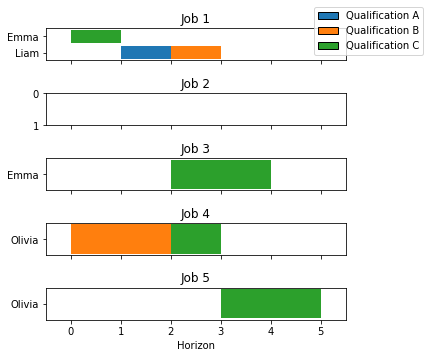

In [31]:
staff_names=[data["staff"][i]["name"] for i in range(staffs)]

def create_chart(res):
    projects_chart = len(res.keys())
    fig, axs = plt.subplots(projects_chart, 1, figsize=(5, 5), sharex=True)
    color_map = {}
    for i in range(qualifs):
        color_map[i]='C'+str(i)

    for i, project in enumerate(res.keys()):
        staff_qualifs = res[project]
        staffs_chart= set([x[0] for x in staff_qualifs.values()])
        staff_map = {staff: staff_names[staff] for i, staff in enumerate(staffs_chart)}
        for t, (staff, qualif) in staff_qualifs.items():
            axs[i].barh(staff_map[staff], 1, left=t, color=color_map[qualif])
        axs[i].set_title(f'Job {project+1}')
        axs[i].invert_yaxis()
    
    handles = [plt.Rectangle((0, 0), 1, 1, color=color, ec="k") for color in color_map.values()]
    labels = [f"Qualification {data['qualifications'][i]}" for i in color_map.keys()]
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))
    
    plt.xlim(-0.5, horizon+0.5)
    plt.xlabel("Horizon")
    plt.tight_layout()
    plt.show()

create_chart(res)


In [32]:
# 4D matrix, Gurobi variables extraction
matrix = np.array([[element.x for element in row] for row in Planning]).reshape(staffs, horizon, projects, qualifs)

# 4D matrix to dataframe
df = pd.DataFrame(np.reshape(matrix, (staffs * horizon, projects * qualifs)),
                  columns=[f"Project {i+1} - Qualification {j+1}" for i in range(projects) for j in range(qualifs)],
                  index=[f"Staff {i+1} - Horizon {j+1}" for i in range(staffs) for j in range(horizon)])

# Add a row of sums
df.loc['sum_row'] = df.sum()

# Add a column of sums
df['sum_column'] = df.sum(axis=1)

df.to_csv("Results/planning_"+path.split("/")[-1].split('.')[0]+".csv",sep=";")

In [33]:
def highlight_cells(val):
    color = 'yellow' if val == 1 else 'red' if val > 1 else ''
    return 'background-color: %s' % color

df.style.applymap(highlight_cells)

,Project 1 - Qualification 1,Project 1 - Qualification 2,Project 1 - Qualification 3,Project 2 - Qualification 1,Project 2 - Qualification 2,Project 2 - Qualification 3,Project 3 - Qualification 1,Project 3 - Qualification 2,Project 3 - Qualification 3,Project 4 - Qualification 1,Project 4 - Qualification 2,Project 4 - Qualification 3,Project 5 - Qualification 1,Project 5 - Qualification 2,Project 5 - Qualification 3,sum_column
Staff 1 - Horizon 1,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,1.000000
Staff 1 - Horizon 2,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,1.000000
Staff 1 - Horizon 3,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,1.000000
Staff 1 - Horizon 4,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,1.000000
Staff 1 - Horizon 5,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,1.000000
Staff 2 - Horizon 1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Staff 2 - Horizon 2,1.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Staff 2 - Horizon 3,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Staff 2 - Horizon 4,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
Staff 2 - Horizon 5,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [34]:
df.to_excel("output.xlsx")

In [35]:
profit=model.objVal
print("profit",profit)

sum_switch=0
for staff in range(staffs):
    sum_switch+=sum_staff_jobs[staff].x
    
moyenne_switch=sum_switch/len(sum_staff_jobs)

print("moyenne_switch",moyenne_switch)

max_duration=Max_duration_lenght.x
print("max_duration",max_duration)

triplet=(profit,moyenne_switch,max_duration)

#save in a text doc the new triplet 

profit 65.0
moyenne_switch 2.0
max_duration 3.0
